[*********************100%***********************]  1 of 1 completed


Μέση τιμή hedging-error (όλων των trades, άγκυρα ανά μήνα): -106.364869

Μέσο hedging-error ανά μήνα έναρξης:
trade_start
2024-10   -576.062108
2024-11   -338.724980
2024-12    130.195825
2025-01    120.249404
2025-02    -59.050043
2025-03   -511.848804
2025-04   -498.052712
2025-05   -181.749443
2025-06   -398.847496
2025-07   -537.300557
2025-08   -483.625145
2025-09   -454.118570
Freq: M, Name: hedging_error, dtype: float64

=== Last 5 trades ===
train_start  train_end trade_start  trade_end         S0         ST          K  sigma_ann  premium0   payoff  portfolio_value  hedging_error  rehedges
 2025-06-04 2025-09-04  2025-09-04 2025-09-09 338.529999 346.970001 338.529999   0.566788  9.002721 8.440002      -516.787635    -525.227638         3
 2025-06-05 2025-09-05  2025-09-05 2025-09-09 350.839996 346.970001 350.839996   0.476904  7.024709 0.000000       170.354904     170.354904         2
 2025-06-06 2025-09-05  2025-09-08 2025-09-09 346.399994 346.970001 346.399994   0.476107  3.

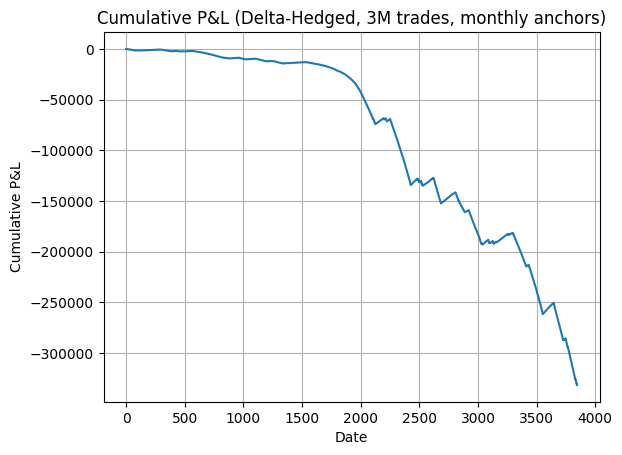

Αριθμός trades: 3845
Μέσο hedging error: -106.36486886996678
Διάμεσος: -25.16327563156066
Τυπική απόκλιση: 206.3018214441945
Ποσοστό θετικών: 44.36931079323797 %
Συνολικό hedging error: -408972.9208050223


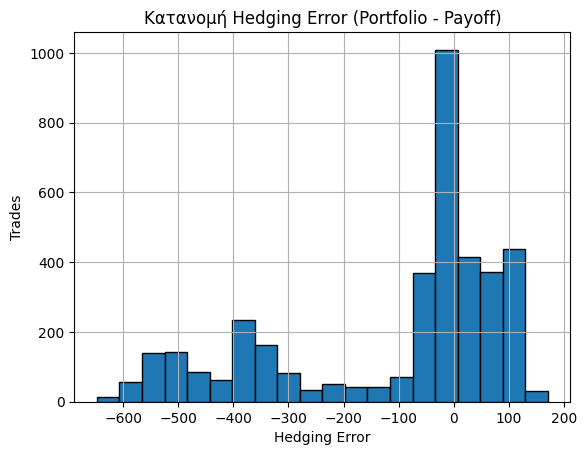

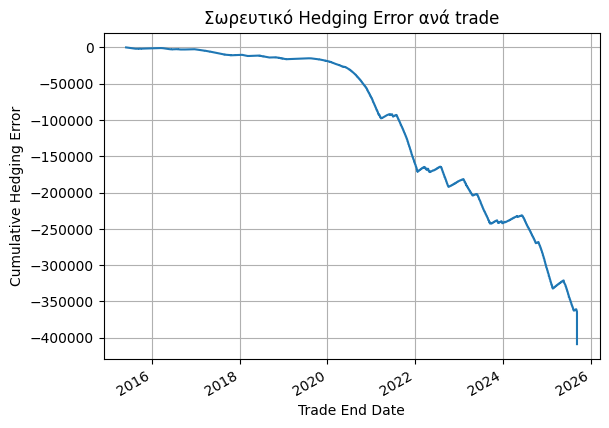

In [ ]:
# === One-cell BS quarterly backtest with monthly anchors (Colab-ready) ===
!pip -q install yfinance pandas numpy matplotlib

import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from dataclasses import dataclass
from typing import Tuple, List, Optional

# ------------------------- helpers -------------------------
def N(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_price_delta(S: float, K: float, T: float, r: float, q: float, sigma: float, call: bool=True) -> Tuple[float, float]:
    """Black–Scholes price and delta (continuous compounding)."""
    if T <= 0.0 or sigma <= 0.0:
        if call:
            return max(S - K, 0.0), (1.0 if S > K else 0.0)
        else:
            return max(K - S, 0.0), (-1.0 if S < K else 0.0)
    vsqrtT = sigma * math.sqrt(T)
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / vsqrtT
    d2 = d1 - vsqrtT
    if call:
        price = S * math.exp(-q * T) * N(d1) - K * math.exp(-r * T) * N(d2)
        delta = math.exp(-q * T) * N(d1)
    else:
        price = K * math.exp(-r * T) * N(-d2) - S * math.exp(-q * T) * N(-d1)
        delta = -math.exp(-q * T) * N(-d1)
    return float(price), float(delta)

def annualize_vol_from_returns(ret: pd.Series) -> float:
    """Annualized vol from daily log-returns (sqrt(252)) — always on 1-D Series."""
    if isinstance(ret, pd.DataFrame):
        ret = ret.iloc[:, 0]
    s = pd.to_numeric(ret, errors="coerce").dropna()
    if len(s) < 2:
        return float("nan")
    return float(s.std(ddof=1) * math.sqrt(252.0))

@dataclass
class TradeResult:
    train_start: pd.Timestamp
    train_end: pd.Timestamp
    trade_start: pd.Timestamp
    trade_end: pd.Timestamp
    S0: float
    ST: float
    K: float
    sigma_ann: float
    premium0: float
    payoff: float
    portfolio_value: float
    hedging_error: float
    rehedges: int

def align_to_index(idx: pd.DatetimeIndex, dt: pd.Timestamp, *, side: str="left") -> Optional[pd.Timestamp]:
    if len(idx) == 0:
        return None
    if dt in idx:
        return dt
    pos = idx.searchsorted(dt, side="left")
    if side == "left":
        pos = max(0, min(pos - 1, len(idx) - 1))
    else:
        pos = max(0, min(pos, len(idx) - 1))
    return idx[pos]

def get_close_series(df: pd.DataFrame, ticker: str = None) -> pd.Series:
    """
    Επιστρέφει καθαρό pd.Series με Close από df με απλές ή MultiIndex στήλες.
    Αν δοθεί ticker, επιχειρεί να επιλέξει τη σωστή στήλη για αυτόν.
    """
    # Simple columns
    if not isinstance(df.columns, pd.MultiIndex):
        if "Close" in df.columns:
            return pd.to_numeric(df["Close"], errors="coerce")
        # fallback: αν υπάρχει μία μόνο στήλη
        if df.shape[1] == 1:
            return pd.to_numeric(df.iloc[:, 0], errors="coerce")
        raise ValueError("No 'Close' column found.")
    # MultiIndex
    if ("Close", ticker) in df.columns:
        return pd.to_numeric(df[("Close", ticker)], errors="coerce")
    if (ticker, "Close") in df.columns:
        return pd.to_numeric(df[(ticker, "Close")], errors="coerce")
    # try xs over levels
    for lvl in range(df.columns.nlevels):
        try:
            sub = df.xs("Close", axis=1, level=lvl)
            if isinstance(sub, pd.DataFrame):
                if ticker and ticker in sub.columns:
                    return pd.to_numeric(sub[ticker], errors="coerce")
                return pd.to_numeric(sub.iloc[:, 0], errors="coerce")
            return pd.to_numeric(sub, errors="coerce")
        except Exception:
            continue
    # last fallback
    if df.shape[1] == 1:
        return pd.to_numeric(df.iloc[:, 0], errors="coerce")
    raise ValueError("Could not extract a 1-D Close series from the DataFrame.")

def backtest_monthly_anchors(
    df: pd.DataFrame,
    start_anchor: str,
    end_anchor: str,
    *,
    training_months: int = 3,
    trading_months: int = 3,
    step_months: int = 1,        # << άγκυρα ανά μήνα (1). Βάλε 3 για ανά τρίμηνο.
    K_offset: float = 1.00,      # 1.00=ATM (0.95 ITM / 1.05 OTM)
    r: float = 0.02,
    q: float = 0.0,
    call: bool = True,
    tc_perc: float = 0.0005,
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Rolling backtest:
      • Training σ: τα προηγούμενα `training_months` (προεπιλ. 3).
      • Trading παράθυρο: `trading_months` (προεπιλ. 3).
      • Νέα άγκυρα κάθε `step_months` μήνες (προεπιλ. 1 ⇒ ανά μήνα).
    """
    # Εξασφάλισε ότι υπάρχει Close ως Series
    close = get_close_series(df, ticker=None).astype(float)
    px = close.to_frame(name="Close").dropna().sort_index()
    idx = px.index

    anchor = pd.Timestamp(start_anchor)
    last = pd.Timestamp(end_anchor)
    results: List[TradeResult] = []
    days_in_year = 252.0

    while anchor < last:
        train_start_cal = anchor - pd.DateOffset(months=training_months)
        train_end_cal   = anchor
        trade_start_cal = anchor
        trade_end_cal   = anchor + pd.DateOffset(months=trading_months)

        # Ευθυγράμμιση σε διαθέσιμες μέρες (business days του df)
        train_start = align_to_index(idx, train_start_cal, side="right")
        train_end   = align_to_index(idx, train_end_cal,   side="left")
        trade_start = align_to_index(idx, trade_start_cal, side="right")
        trade_end   = align_to_index(idx, trade_end_cal,   side="left")

        if any(d is None for d in [train_start, train_end, trade_start, trade_end]):
            break
        if trade_end <= trade_start:
            break

        # === TRAIN σ από το προηγούμενο training window ===
        train_slice = px.loc[train_start:train_end, "Close"]
        logret = np.log(train_slice).diff()
        sigma_ann = annualize_vol_from_returns(logret)
        if not np.isfinite(sigma_ann):
            anchor = anchor + pd.DateOffset(months=step_months)
            continue

        # === TRADE  ===
        S0 = float(px.loc[trade_start, "Close"])
        K = float(S0 * K_offset)  # για fixed strike: αντικατάστησε με π.χ. K = 300.0
        # ACT/365 approx για το συνολικό T (μόνο για αρχικοποίηση)
        T_years_total = (trade_end - trade_start).days / 365.0
        price0, delta = bs_price_delta(S0, K, T_years_total, r, q, sigma_ann, call)

        cash = -price0
        shares = delta
        cash -= abs(shares) * S0 * tc_perc

        trade_days = px.loc[trade_start:trade_end].index
        rehedges = 0

        for t in trade_days[1:]:
            T_left = max((trade_end - t).days, 0) / 365.0
            S = float(px.loc[t, "Close"])
            _, new_delta = bs_price_delta(S, K, T_left, r, q, sigma_ann, call)

            hedge = new_delta - shares
            if hedge != 0.0:
                cash -= hedge * S
                cash -= abs(hedge) * S * tc_perc
                shares = new_delta
                rehedges += 1

            cash *= math.exp(r / days_in_year)

        ST = float(px.loc[trade_end, "Close"])
        payoff = max(ST - K, 0.0) if call else max(K - ST, 0.0)

        cash_final = cash - shares * ST
        portfolio_value = payoff + cash_final
        hedging_error = portfolio_value - payoff  # = cash_final

        results.append(
            TradeResult(
                train_start, train_end, trade_start, trade_end,
                S0, ST, K, sigma_ann, price0,
                payoff, portfolio_value, hedging_error, rehedges
            )
        )

        # ΝΕΑ ΑΓΚΥΡΑ: κάθε step_months
        anchor = anchor + pd.DateOffset(days=1)

    if not results:
        return pd.DataFrame(), pd.Series(dtype=float, name="equity")

    res_df = pd.DataFrame([r.__dict__ for r in results])
    res_df["cum_portfolio_value"] = res_df["portfolio_value"].cumsum()
    equity = res_df["cum_portfolio_value"].rename("equity")
    return res_df, equity

# ------------------------- RUN (TSLA example) -------------------------
# Κατέβασε TSLA (auto_adjust=True για καθαρή adjusted Close)
df_full = yf.download("TSLA", start="2014-01-01", end=None, auto_adjust=True)
df_full.index = pd.to_datetime(df_full.index)

results, equity = backtest_monthly_anchors(
    df_full,
    start_anchor="2015-03-01",
    end_anchor=pd.Timestamp.today().strftime("%Y-%m-%d"),
    training_months=3,
    trading_months=3,
    step_months=1,     # <<< ΑΓΚΥΡΑ ΑΝΑ ΜΗΝΑ
    K_offset=1.00,     # ATM (βάλε 0.95/1.05 για ITM/OTM, ή αντικατάστησε με fixed K)
    r=0.02,
    q=0.0,             # TSLA δεν δίνει μέρισμα
    tc_perc=0.0002,    # 2 bps ανά hedge trade
)

if results.empty:
    raise RuntimeError("No results produced—check date range/data.")

# === ΖΗΤΟΥΜΕΝΟ: μέση τιμή hedging-error ===
mean_hedge_error = float(results["hedging_error"].mean())
print(f"Μέση τιμή hedging-error (όλων των trades, άγκυρα ανά μήνα): {mean_hedge_error:.6f}")

# Επίσης: μέσο hedging-error ομαδοποιημένο ανά μήνα έναρξης (YYYY-MM)
monthly_avg = results.groupby(results["trade_start"].dt.to_period("M"))["hedging_error"].mean()
print("\nΜέσο hedging-error ανά μήνα έναρξης:")
print(monthly_avg.tail(12))  # δείξε τους τελευταίους 12 μήνες για συντομία

# Προβολή τελευταίων 5 trades
cols = ["train_start","train_end","trade_start","trade_end","S0","ST","K",
        "sigma_ann","premium0","payoff","portfolio_value","hedging_error","rehedges"]
print("\n=== Last 5 trades ===")
print(results[cols].tail(5).to_string(index=False))

# --- Plot equity curve ---
plt.figure()
equity.plot(title="Cumulative P&L (Delta-Hedged, 3M trades, monthly anchors)")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L")
plt.grid(True)
plt.show()



# === Hedging Error Analysis ===

# Πάρε μόνο τη στήλη hedging_error
hedge_err = results.set_index("trade_end")["hedging_error"]

# Βασικά στατιστικά
print("Αριθμός trades:", hedge_err.shape[0])
print("Μέσο hedging error:", hedge_err.mean())
print("Διάμεσος:", hedge_err.median())
print("Τυπική απόκλιση:", hedge_err.std())
print("Ποσοστό θετικών:", (hedge_err > 0).mean()*100, "%")
print("Συνολικό hedging error:", hedge_err.sum())

# --- Ιστόγραμμα κατανομής ---
import matplotlib.pyplot as plt
plt.figure()
hedge_err.hist(bins=20, edgecolor="black")
plt.title("Κατανομή Hedging Error (Portfolio - Payoff)")
plt.xlabel("Hedging Error")
plt.ylabel("Trades")
plt.grid(True)
plt.show()

# --- Καμπύλη (σωρευτικό hedging error) ---
hedge_err.cumsum().plot(title="Σωρευτικό Hedging Error ανά trade")
plt.xlabel("Trade End Date")
plt.ylabel("Cumulative Hedging Error")
plt.grid(True)
plt.show()
